# Generative Models

## GANs & VAE

### HW4

**Full Name:** Amirhossein Alamdar

**SID:** 400105144


In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.


+ Complete the `TODO` parts in the code accordingly.

In [1]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
DEVICE = 'cpu'

# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [12]:
transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ])

In [13]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

In [14]:
num_threads = 2
batch_size = 32

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = num_threads)
val_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = num_threads)

# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        ##########################################################
        self.activation = nn.ReLU()

        self.fc1 = nn.Linear(input_dim, hidden_dim, bias = False)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, latent_dim, bias = False)
        self.bn2 = nn.BatchNorm1d(latent_dim)

        self.fc_mu = nn.Linear(latent_dim, latent_dim)
        self.fc_sd = nn.Linear(latent_dim, latent_dim)

        # Define your variational encoder layers.
        ##########################################################

        
    def forward(self, x):

        ##########################################################
        x = x.view(x.shape[0], -1)
        x = self.bn1(self.activation(self.fc1(x)))
        x = self.bn2(self.activation(self.fc2(x)))
        z_mean = self.fc_mu(x)
        z_log_var = self.fc_sd(x)
        # Convert input `x` to mean and log variance of latent
        # space which is then used to sample data for the decoder.
        ##########################################################

        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        ##############################        
        # Define your decoder layers.
        ##############################
        self.activation = nn.ReLU()

        self.fc1 = nn.Linear(latent_dim, hidden_dim, bias = False)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, output_dim, bias = False)
        self.bn2 = nn.BatchNorm1d(output_dim)


    def forward(self, z, c, h, w):
        ########################################
        z = self.bn1(self.activation(self.fc1(z)))
        z = self.bn2(self.activation(self.fc2(z)))
        # Decode the latent vector `z` to images.
        ########################################

        return z.view(z.shape[0], c, h, w)

In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):
        ##########################################################
        b, c, h, w = x.shape
        samples = torch.randn(1).to(DEVICE)

        z_mean, z_log_var = self.encoder(x)
        z = z_mean * samples + z_log_var
        image = self.decoder(z, c, h, w)
        # Using the encoder and decoder you have defined, encode the
        # image to the latent space and then reconstruct it.
        # Use the eeparameterization trick to ensure gradient flow.
        ##########################################################

        return image, z_mean, z_log_var

In [9]:
def reconstruct_images(vae, images):
    with torch.no_grad():
        recon_images, _, _ = vae(images)
    return recon_images

In [10]:
DEVICE = 'cuda'

In [5]:
def loss_function(output, x, mu, logvar):
    recon_loss = F.mse_loss(output, x, reduction='sum') / batch_size
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.002  * kl_loss

def train_vae(dataloader, latent_dim, hidden_dim, input_dim, learning_rate=1e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizer and VAE model.
    ###############################################
    model = VAE(input_dim, hidden_dim, latent_dim)
    model.to(DEVICE)
    # KL = nn.KLDivLoss(reduction="batchmean")
    # MSE = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    sample_images, _ = next(iter(val_loader))
    sample_images = sample_images.to(DEVICE)

    recon_images = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, data in pbar:
                data[0] = data[0].to(DEVICE)
                ###############################################
                outputs, mu, sd = model(data[0])
                
                loss = loss_function(outputs, data[0], mu, torch.log(sd**2 + 1e-6))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                # Calculate the loss.
                # (optional) Use the KL divergence loss to normalize the
                # output distribution of decoder.
                ###############################################

            print('Loss: {:.4f}'.format(train_loss / len(dataloader.dataset)))
    
        # TODO
        # Reconstruct `sample_images` and plot first 4 images after each epoch
        # This is used to visualize the progress
        recon_images.append(reconstruct_images(model, sample_images).cpu())
        # Plot the first 4 images\
        
    return model, recon_images

In [19]:
torch.cuda.empty_cache()
model, recon_images = train_vae(train_loader, latent_dim=256, hidden_dim=512,input_dim = 28*28, learning_rate=1e-3, num_epochs=20)

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 4.6540


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.7249


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.6559


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.5902


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.4751


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.4254


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.3664


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.3270


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.3012


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.2937


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.2779


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.2764


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.2720


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.2665


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.2600


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.2606


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.2558


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.2559


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.2549


  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 0.2494


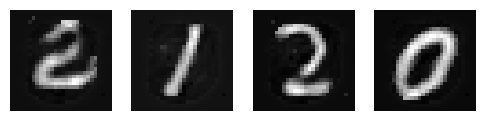

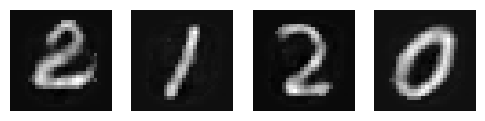

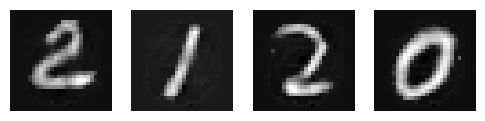

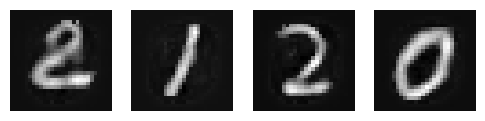

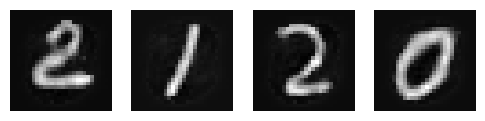

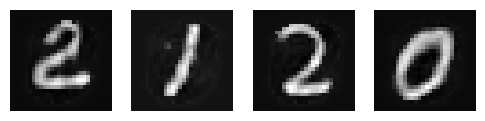

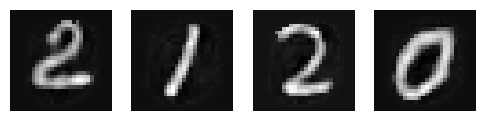

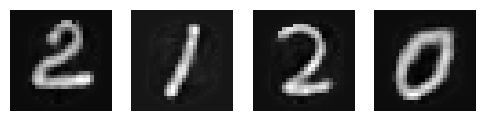

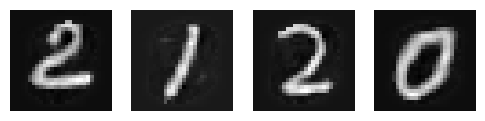

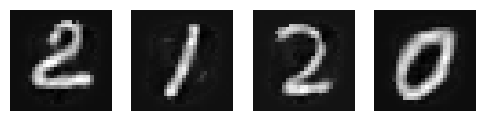

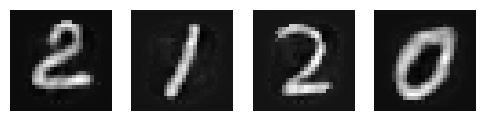

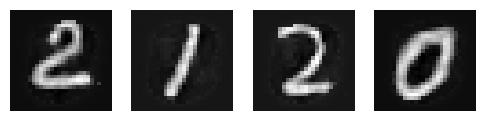

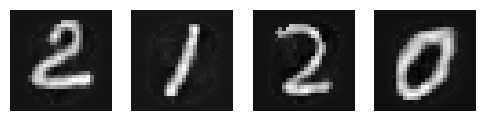

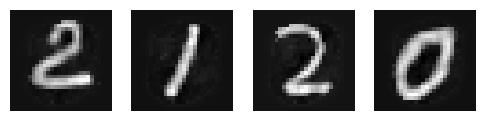

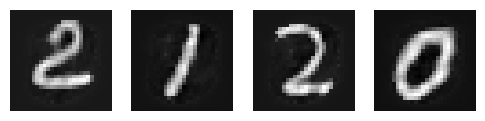

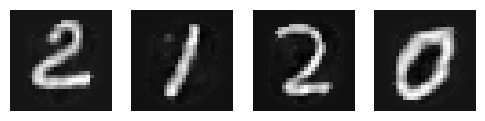

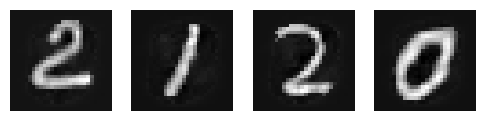

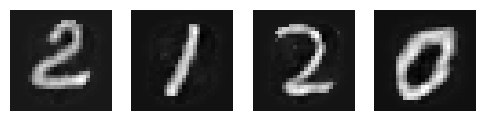

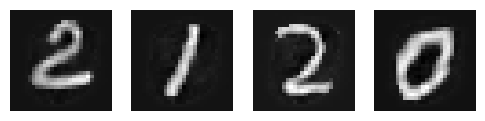

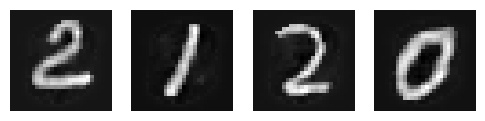

In [20]:
for j in range(len(recon_images)):

    images = recon_images[j][:4]
    fig, axes = plt.subplots(1, 4, figsize=(6, 2))

    for i in range(4):
        image = images[i].permute(1, 2, 0)  # Change tensor shape from (C, H, W) to (H, W, C)
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')

    plt.show()

In [21]:
torch.save(model.state_dict(), 'VAE_weights.pth')

# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim, input_dim):
        super(Generator, self).__init__()

        #######################
        # TODO
        # Define your generator
        #######################

        # self.img_shape = img_shape

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, input_dim),
            nn.Tanh()
        )

        # self.model = nn.Sequential(
        #     nn.Linear(latent_dim, 512),
        #     nn.LeakyReLU(0.2),
        #     nn.Linear(512, input_dim),
        #     nn.Tanh(),  # We normalize inputs to [-1, 1] so make outputs [-1, 1]
        # )

    def forward(self, z):
        ##############################################
        # TODO
        # generate an image using `z` vector, sampled
        # from a prior distribution.
        # Reshape the result to the shape of original images
        ##############################################
        # B, C, H, W = z.shape
        # z = z.reshape(B, H*W)
        z = self.model(z)
        img = z.reshape(z.shape[0], 1, 28, 28)
        return img

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()

        ###########################
        # TODO
        # Define your discriminator
        ###########################

        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
        # self.model = nn.Sequential(
        #     nn.Linear(input_dim, 512),
        #     nn.LeakyReLU(0.2),
        #     nn.Linear(512, 1),
        #     nn.Sigmoid(),
        # )

    def forward(self, img):
        ##############################################
        # TODO
        # Predict whether each image in `img` is real or fake.
        ##############################################
        B, C, H, W = img.shape
        img = img.reshape(B, H*W)
        x = self.model(img)
        return x

In [19]:
def train_gan(dataloader, latent_dim, img_shape=(1, 28, 28), learning_rate=3e-4, num_epochs=100):
    ###############################################
    # TODO
    # Define the loss fc, optimizers, generator and discriminator.
    ###############################################
    generator = Generator(latent_dim, 28*28)
    discriminator = Discriminator(28*28)
    generator.to(DEVICE)
    discriminator.to(DEVICE)
    adversarial_loss = nn.BCELoss()
    optimizer_G = torch.optim.Adam(generator.parameters(), lr = learning_rate)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

    Tensor = torch.cuda.FloatTensor if DEVICE=='cuda' else torch.FloatTensor

    generated_imgs = []

    for epoch in range(num_epochs):
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (imgs, _) in pbar:

                real_imgs = torch.autograd.Variable(imgs.type(Tensor)).to(DEVICE)
                ##########################################################
                # TODO
                valid = torch.autograd.Variable(Tensor(imgs.size(0), 1).fill_(1.0).to(DEVICE), requires_grad=False)
                fake = torch.autograd.Variable(Tensor(imgs.size(0), 1).fill_(0.0).to(DEVICE), requires_grad=False)
                

                optimizer_G.zero_grad()
                z = torch.autograd.Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))).to(DEVICE))
                
                gen_imgs = generator(z)

                # Loss measures generator's ability to fool the discriminator
                g_loss = adversarial_loss(discriminator(gen_imgs), valid)

                g_loss.backward()
                optimizer_G.step()

                # ---------------------
                #  Train Discriminator
                # ---------------------

                optimizer_D.zero_grad()

                # Measure discriminator's ability to classify real from generated samples
                real_loss = adversarial_loss(discriminator(real_imgs), valid)
                fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2

                d_loss.backward()
                optimizer_D.step()

                # Calculate the loss for the Generator and the Discriminator.
                ##########################################################

                # TODO
                # Calculate and fill discriminator and generator losses
                pbar.set_description("[epoch: {}/{}] [D loss: {:.4f}] [G loss: {:.4f}]".format(epoch, num_epochs, d_loss.item(), g_loss.item()))

        # TODO
        fig, axes = plt.subplots(1, 4, figsize=(6, 2))

        for i in range(4):
            image = gen_imgs[i].detach().cpu().permute(1, 2, 0)  # Change tensor shape from (C, H, W) to (H, W, C)
            axes[i].imshow(image, cmap='gray')
            axes[i].axis('off')

        plt.show()
        # Plot generated images after each epoch
        if epoch % 10 == 0:
            torch.save(generator.state_dict(), f'./GAN_checkpoints/gen_weights_{epoch}.pth')
        
    return generator, discriminator

  0%|          | 0/1563 [00:00<?, ?it/s]

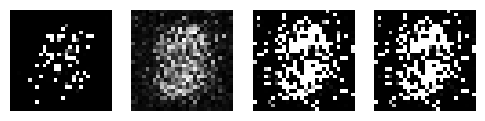

  0%|          | 0/1563 [00:00<?, ?it/s]

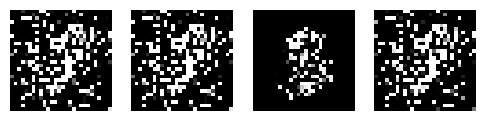

  0%|          | 0/1563 [00:00<?, ?it/s]

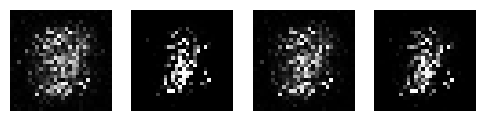

  0%|          | 0/1563 [00:00<?, ?it/s]

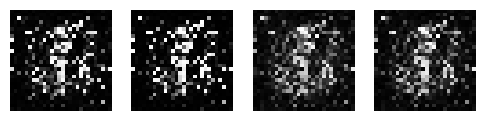

  0%|          | 0/1563 [00:00<?, ?it/s]

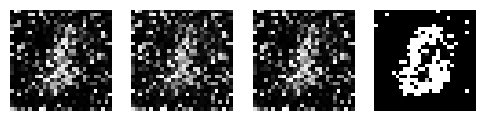

  0%|          | 0/1563 [00:00<?, ?it/s]

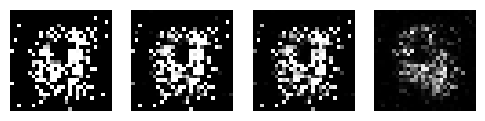

  0%|          | 0/1563 [00:00<?, ?it/s]

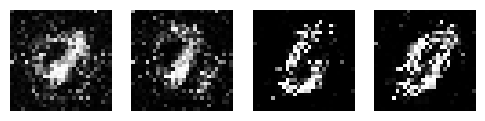

  0%|          | 0/1563 [00:00<?, ?it/s]

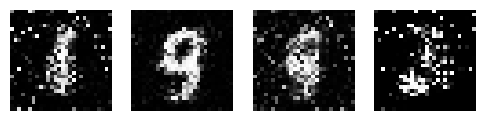

  0%|          | 0/1563 [00:00<?, ?it/s]

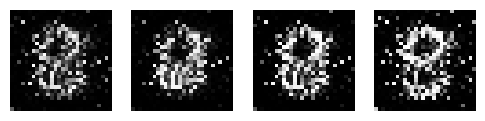

  0%|          | 0/1563 [00:00<?, ?it/s]

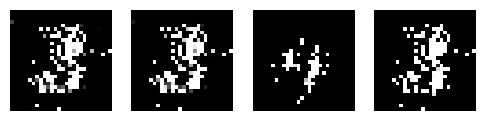

  0%|          | 0/1563 [00:00<?, ?it/s]

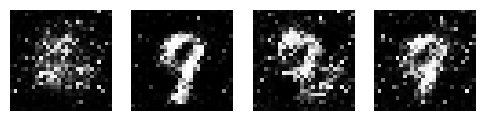

  0%|          | 0/1563 [00:00<?, ?it/s]

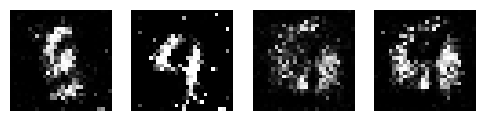

  0%|          | 0/1563 [00:00<?, ?it/s]

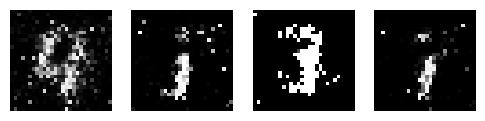

  0%|          | 0/1563 [00:00<?, ?it/s]

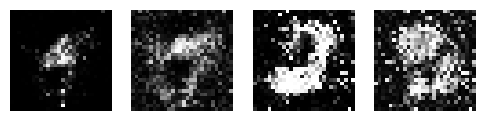

  0%|          | 0/1563 [00:00<?, ?it/s]

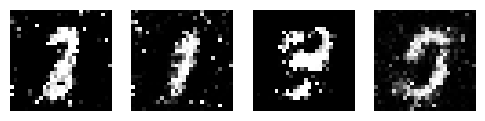

  0%|          | 0/1563 [00:00<?, ?it/s]

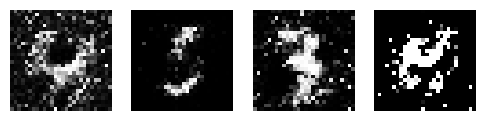

  0%|          | 0/1563 [00:00<?, ?it/s]

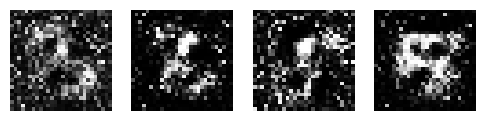

  0%|          | 0/1563 [00:00<?, ?it/s]

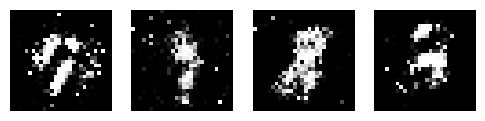

  0%|          | 0/1563 [00:00<?, ?it/s]

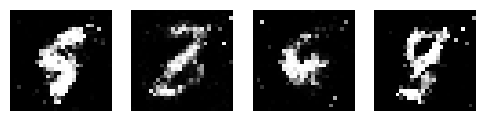

  0%|          | 0/1563 [00:00<?, ?it/s]

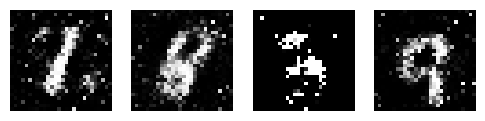

  0%|          | 0/1563 [00:00<?, ?it/s]

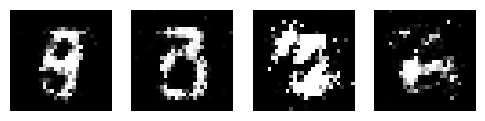

  0%|          | 0/1563 [00:00<?, ?it/s]

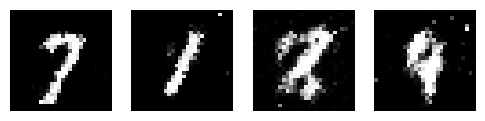

  0%|          | 0/1563 [00:00<?, ?it/s]

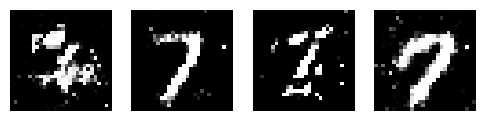

  0%|          | 0/1563 [00:00<?, ?it/s]

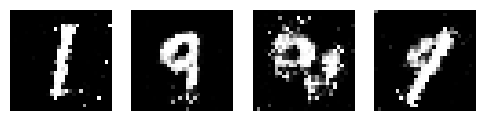

  0%|          | 0/1563 [00:00<?, ?it/s]

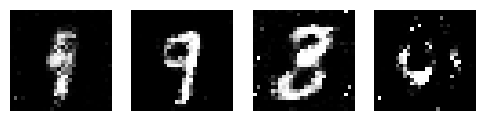

  0%|          | 0/1563 [00:00<?, ?it/s]

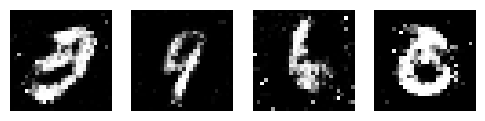

  0%|          | 0/1563 [00:00<?, ?it/s]

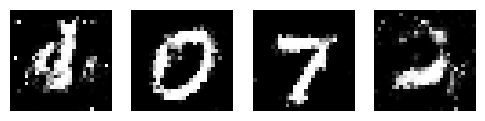

  0%|          | 0/1563 [00:00<?, ?it/s]

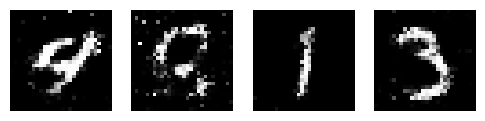

  0%|          | 0/1563 [00:00<?, ?it/s]

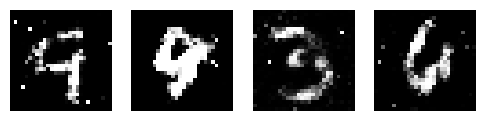

  0%|          | 0/1563 [00:00<?, ?it/s]

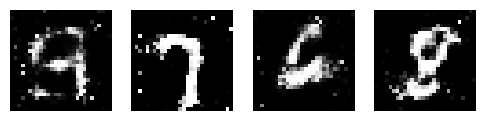

  0%|          | 0/1563 [00:00<?, ?it/s]

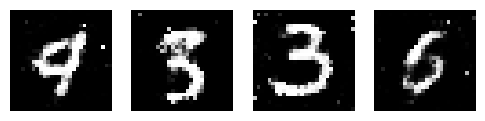

  0%|          | 0/1563 [00:00<?, ?it/s]

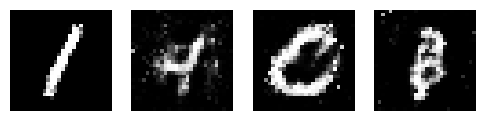

  0%|          | 0/1563 [00:00<?, ?it/s]

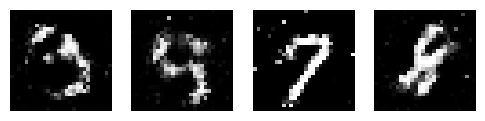

  0%|          | 0/1563 [00:00<?, ?it/s]

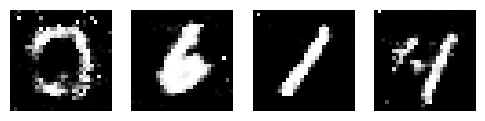

  0%|          | 0/1563 [00:00<?, ?it/s]

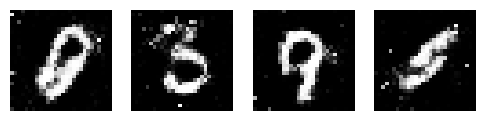

  0%|          | 0/1563 [00:00<?, ?it/s]

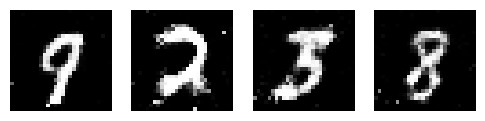

  0%|          | 0/1563 [00:00<?, ?it/s]

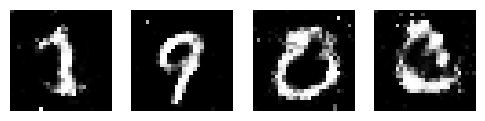

  0%|          | 0/1563 [00:00<?, ?it/s]

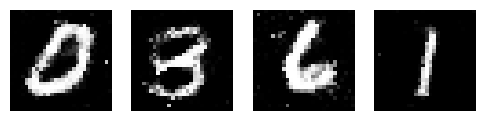

  0%|          | 0/1563 [00:00<?, ?it/s]

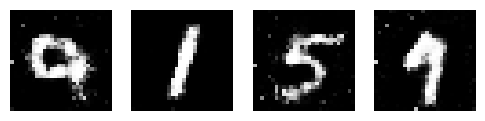

  0%|          | 0/1563 [00:00<?, ?it/s]

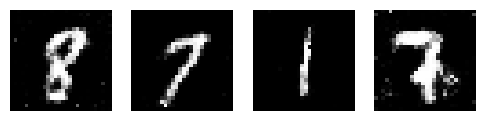

  0%|          | 0/1563 [00:00<?, ?it/s]

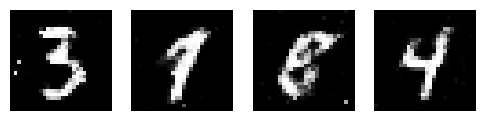

In [21]:
DEVICE = 'cuda'
torch.cuda.empty_cache()
generator, discriminator = train_gan(train_loader, 128, num_epochs = 41)

# Compare

Use validation dataset to plot and compare the results of your trained models.

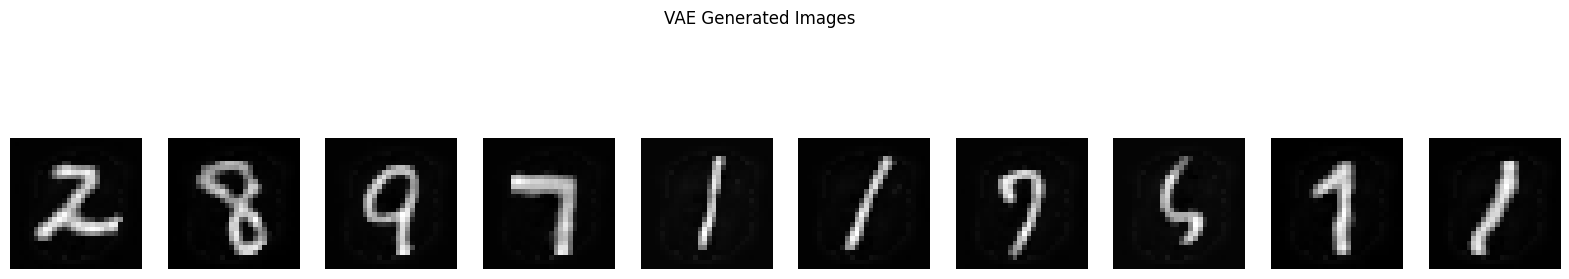

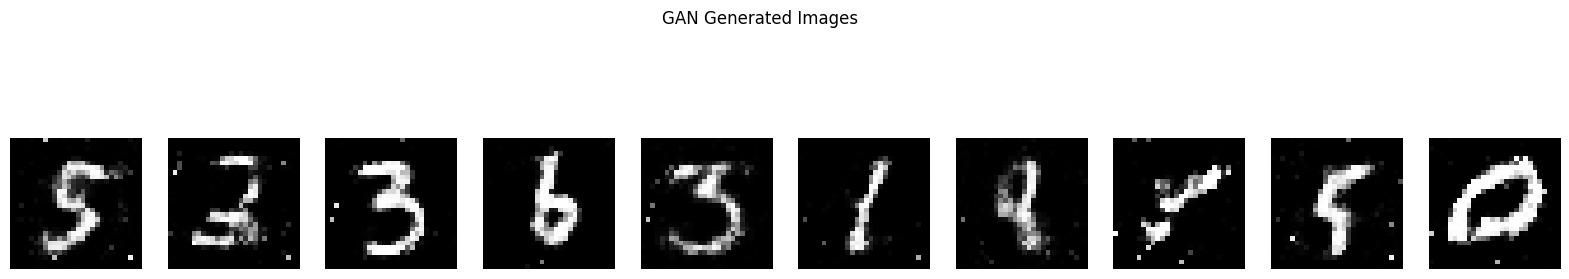

In [34]:
# TODO
# Comparison of the generated images
import random
transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

data = datasets.MNIST(root='data/', download=False, transform=transformation)

DEVICE = 'cpu'
gan_model = Generator(128, 28*28)
vae_model = VAE(28*28, 512, 256)
gan_model.load_state_dict(torch.load('./GAN_checkpoints/gen_weights_40.pth'))
vae_model.load_state_dict(torch.load('VAE_weights.pth'))
gan_model.eval()
vae_model.eval()

def plot_images(model, title, num_images=10, latent_dim=128, type = 'GAN', data = None):

    with torch.no_grad():
        normal_noise = torch.randn(num_images, latent_dim)
        if type == 'GAN':
            generated_img = model(normal_noise)
        else:
            indices = random.sample(range(len(data)), num_images)
            original_images = [data[idx][0] for idx in indices]
            org_images = torch.stack(original_images)
            generated_img, _, _ = model(org_images)
            
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 4))
    fig.suptitle(title)
    
    for i in range(num_images):
        axes[i].imshow(generated_img[i].permute(1, 2, 0), cmap='gray')
        axes[i].axis('off')

plot_images(vae_model, 'VAE Generated Images', latent_dim = 256, type = 'VAE', data=data)
plot_images(gan_model, 'GAN Generated Images')
plt.show()

### note that both models are using fully connected layers and don't have any conv layers. Also VAE's latent dim is twice longer than GAN so we should consider different scenarios.